In [1]:
import numpy as np
import pandas as pd
X_train_s = np.load('data/X_train_s.npy' )
X_test_s = np.load('data/X_test_s.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

feature_names = np.load('data/feature_names.npy')


# Logistic Regression

Logistic regression is a type of regression analysis used when predicting classes as opposed to numerical values. In
this case, its goal is to predict whether a customer is a satisfied or dissatisfied customer. In order to fine-tune the
model, a cross-validated grid-search will be performed running various combination of tuning parameters.

In [2]:
from sklearn.model_selection import GridSearchCV

def find_best_parameters(model,parameters, x, y):
    gridSearch = GridSearchCV(model,parameters)
    gridSearch.fit(x,y)
    return gridSearch


In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
# logRegGrid = {
#     'penalty': ['elasticnet'],
#     'solver': ['saga'],
#     'fit_intercept': [True,False],
#     'class_weight': ['balanced',None],
#     'tol': [.0001, .01, 1, 10, 100],
#     'C': [.01, 1, 10, 100],
#     'l1_ratio': np.linspace(0,1,num=4),
#     'n_jobs':[-1]
# }
#
# best = find_best_parameters(LogisticRegression(),logRegGrid,X_train_s,y_train)



Given the best parameters from the grid search, the following model achieved a score of 87.36%. The model was balanced
in predicting satisfied and unsatisfied customers. This is shown within the F1-score.

In [5]:
# for param in best.best_params_:
#     print('{} : {}'.format(param,best.best_params_[param]))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     14675
           1       0.89      0.81      0.85     11223

    accuracy                           0.87     25898
   macro avg       0.88      0.87      0.87     25898
weighted avg       0.87      0.87      0.87     25898



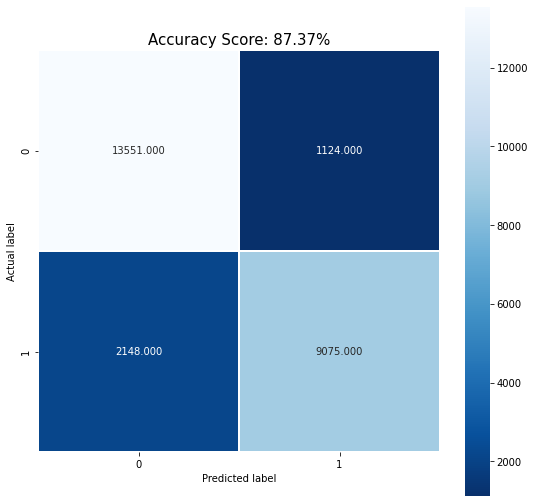

In [20]:
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

logReg = LogisticRegression(
    C=100,
    tol=.01,
    class_weight=None,
    fit_intercept=False,
    l1_ratio=1.0,
    max_iter=1000,
    penalty='elasticnet',
    solver='saga'
)

logReg.fit(X_train_s, y_train)
predictions = logReg.predict(X_test_s)
score = logReg.score(X_test_s, y_test)

cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {:.2f}%'.format(score*100), size = 15);

print(classification_report(y_test, predictions))

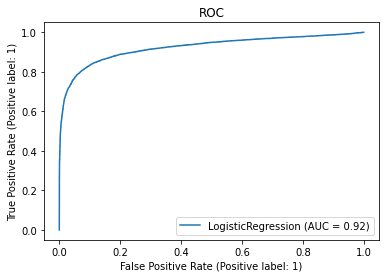

<function sklearn.metrics._plot.roc_curve.plot_roc_curve(estimator, X, y, *, sample_weight=None, drop_intermediate=True, response_method='auto', name=None, ax=None, pos_label=None, **kwargs)>

In [21]:
from sklearn.metrics import plot_roc_curve
rf_roc = plot_roc_curve(logReg, X_test_s, y_test)
plt.title("ROC")
plt.show()
metrics.plot_roc_curve

# Feature Selection

In an attempt to improve accuracy and reduce the complexity of the model, feature selection could help. In this case,
the following will systematically choose the best number of features by minimizing the mean absolute error.

In [7]:
from sklearn import feature_selection, model_selection

def select_features(training_data,target,model, percentiles, scoring='neg_mean_absolute_error',cv=5):
    results = []
    for i in percentiles:
        fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i)
        X_train_fs = fs.fit_transform(training_data, target)
        scores = model_selection.cross_val_score(model, X_train_fs, target, cv=cv,scoring=scoring)
        results = np.append(results, abs(scores).mean())

    optimal_percentile = np.where(results == results.min())[0]
    print ("Optimal percentile of features:{0}".format(percentiles[optimal_percentile[0]]), "\n")
    optimal_num_features = int(percentiles[optimal_percentile[0]]*training_data.shape[1]/100)
    print ("Optimal number of features:{0}".format(optimal_num_features), "\n")
    return optimal_percentile, results

def plot_coefficients(model, n_features, feature_names):
    plt.figure(figsize=(10,20))
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.barh(range(n_features), model, align='center')
    plt.show()


In [8]:
percentiles = range(1, 101)

optimal_percentile, results = select_features(X_train_s,y_train,logReg,percentiles)


Optimal percentile of features:95 

Optimal number of features:25 



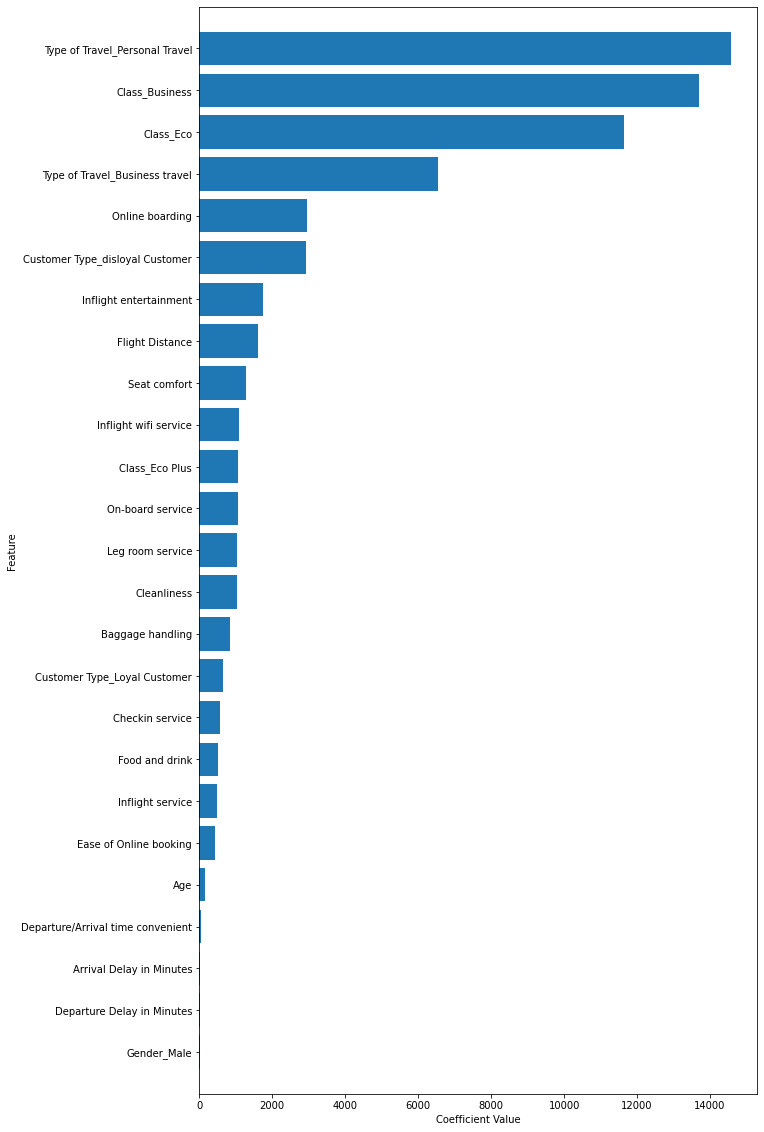

In [9]:
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=93)
X_train_fs = fs.fit_transform(X_train_s, y_train)

features = pd.DataFrame()
features['columns'] = feature_names[fs.get_support()]
features['weights'] = fs.scores_[fs.get_support()]
features = features.sort_values(by='weights')
plot_coefficients(features['weights'], len(features['columns']), features['columns'])


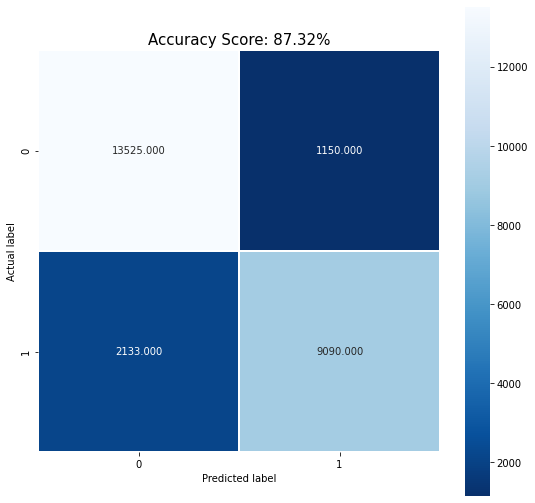

In [10]:

X_test_fs = X_test_s[:,fs.get_support()]

logReg.fit(X_train_fs, y_train)
predictions = logReg.predict(X_test_fs)
score = logReg.score(X_test_fs, y_test)


cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {:.2f}%'.format(score*100), size = 15);

# Recursive Feature Elimination

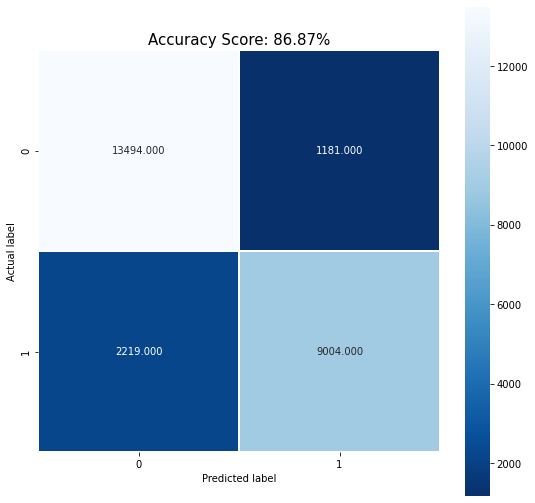

In [11]:
from sklearn.feature_selection import RFE

selector = RFE(logReg)
selector.fit(X_train_s,y_train)
predictions = selector.predict(X_test_s)
score = selector.score(X_test_s, y_test)


cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {:.2f}%'.format(score*100), size = 15);

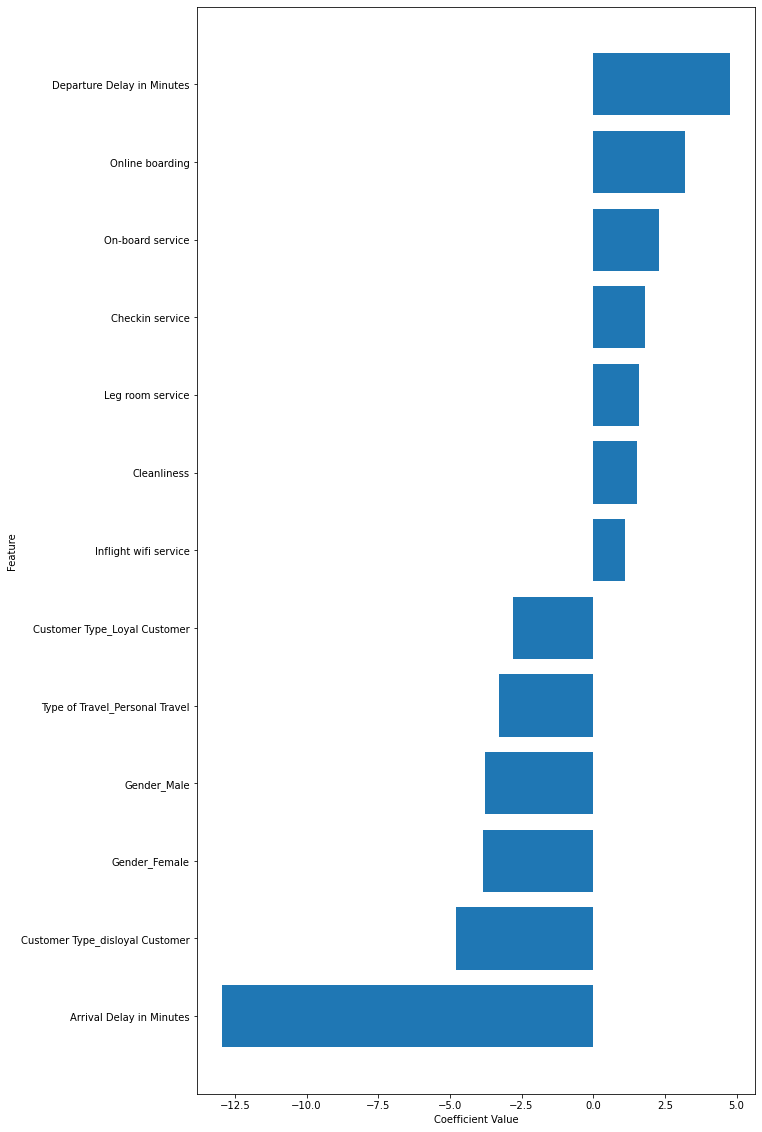

In [12]:
X_train_rfe = selector.transform(X_train_s)

logReg.fit(X_train_rfe, y_train)
features = pd.DataFrame()
features['columns'] = feature_names[selector.support_]
features['weights'] = logReg.coef_[0]
features = features.sort_values(by='weights')
plot_coefficients(features['weights'], len(features['columns']), features['columns'])

# Principal Components Analysis

In [13]:
from sklearn.decomposition import PCA
variance = 0
i = 0
while variance < .95:
    i += 1
    pca = PCA(n_components=i)
    pca.fit(X_train_s)
    variance = pca.explained_variance_ratio_.sum()
    print('{} components capture {:.2f}%'.format(i,variance*100))

print('To capture at least 95% of the variance, {} principal components are needed'.format(i))

1 components capture 25.69%
2 components capture 43.17%
3 components capture 57.01%
4 components capture 64.88%
5 components capture 71.18%
6 components capture 77.01%
7 components capture 81.22%
8 components capture 84.59%
9 components capture 87.07%
10 components capture 89.11%
11 components capture 90.79%
12 components capture 92.13%
13 components capture 93.41%
14 components capture 94.59%
15 components capture 95.63%
To capture at least 95% of the variance, 15 principal components are needed


              precision    recall  f1-score   support

           0       0.85      0.78      0.81     14675
           1       0.74      0.82      0.78     11223

    accuracy                           0.80     25898
   macro avg       0.79      0.80      0.79     25898
weighted avg       0.80      0.80      0.80     25898



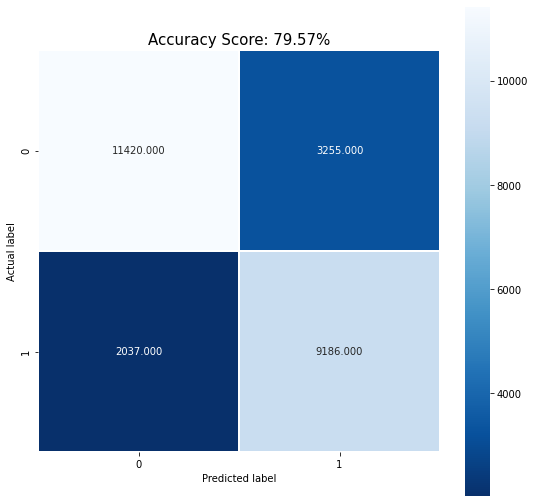

In [18]:
pca_data = pca.fit_transform(X_train_s,y_train)
pca_data_test = pca.fit_transform(X_test_s,y_test)
logReg.fit(pca_data, y_train)
predictions = logReg.predict(pca_data_test)
score = logReg.score(pca_data_test, y_test)

cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {:.2f}%'.format(score*100), size = 15);

print(classification_report(y_test, predictions))

In [14]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train_rfe)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.345696
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.495     
Dependent Variable:  y                AIC:              71646.5504
Date:                2021-03-16 11:05 BIC:              71770.6768
No. Observations:    103589           Log-Likelihood:   -35810.   
Df Model:            12               LL-Null:          -70919.   
Df Residuals:        103576           LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
     Coef.     Std.Err.      z     P>|z|     [0.025       0.975]  
------------------------------------------------------------------
x1    1.1168      0.0412   27.0792 0.0000       1.0360      1.1977
x2    3.2003      0.0466   68.6940 0.0000       3.109

In [27]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings = pd.DataFrame(loadings.T,columns=feature_names)
loadings[loadings > .01]

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,NaN,NaN,NaN,0.056876,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.048202,NaN,NaN,0.392849,NaN,0.410943,0.023649
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.497088,NaN,NaN,0.046468,0.018531,NaN,NaN,0.024674,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.051606,NaN,0.340211,0.174427,NaN,NaN,0.146936,NaN
3,0.015346,0.026132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.101580,NaN,NaN,NaN,0.090944,NaN,0.040642
4,NaN,NaN,NaN,NaN,NaN,NaN,0.063527,NaN,0.084369,0.073074,...,NaN,NaN,NaN,NaN,0.017963,NaN,0.036349,0.015471,NaN,NaN
5,NaN,NaN,NaN,0.049657,NaN,0.013998,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.086836,NaN,0.101146,0.083674,NaN,NaN
6,NaN,NaN,NaN,0.035823,NaN,0.051983,0.067147,NaN,0.070843,NaN,...,NaN,NaN,NaN,NaN,0.106640,NaN,0.110291,0.060963,NaN,0.088694
7,NaN,NaN,0.013708,NaN,NaN,NaN,0.015395,NaN,NaN,0.058255,...,NaN,NaN,NaN,0.019378,NaN,0.028990,NaN,NaN,NaN,0.217179
8,0.013541,NaN,0.060690,NaN,0.042741,NaN,NaN,0.109609,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.016621,NaN,NaN,NaN,0.096693
9,NaN,NaN,NaN,0.071863,NaN,0.118165,NaN,NaN,0.019589,NaN,...,NaN,NaN,NaN,0.026531,NaN,0.051003,NaN,NaN,NaN,0.033323
